# 1.Getting Data:
-----------------

In [180]:
from tensorflow.keras.datasets import fashion_mnist
(xtrain,ytrain), (x_test, y_test) = fashion_mnist.load_data()

# 2. Build Discriminator & warming him up:
-----------------

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D,Dropout,Input,UpSampling2D,BatchNormalization,Flatten,Dense,Reshape,Embedding,concatenate,MaxPooling2D
from tensorflow.keras.utils import plot_model

In [3]:
def discriminator(input_shape,n_classes=10):
  inp_img=Input(shape=input_shape ,name="image")
  inp_label=Input(shape=(1,),name="label")
  emb=Embedding(n_classes,50)(inp_label)
  il=Dense(28*28,activation="relu")(emb)
  il=Reshape((28,28,1))(il)


  con=concatenate([inp_img,il])
  x=Conv2D(64, 3, activation = 'relu')(con)
  x=MaxPooling2D((2,2))(x)
  x=Conv2D(64, 3, activation= 'relu')(x)
  x=MaxPooling2D((2,2))(x)

  x=Flatten()(x)
  x=Dense(32,activation='relu')(x)
  output=Dense(1,activation="sigmoid")(x)
  model = Model(inputs=[inp_img,inp_label],outputs=output,name="discrminator")
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
  return model

In [4]:
D_model=discriminator((28,28,1),n_classes=10)

Model: "discrminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['label[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 image (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                       

In [5]:
plot_model(D_model,show_shapes=True,show_layer_names=True,expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
from keras.utils import Sequence
import numpy as np
class DataGen(Sequence):
  @staticmethod
  def generate_fake(n_batch):
      x=np.random.rand(28*28*1*n_batch)*2 - 1
      x=x.reshape(n_batch,28,28,1)
      label=np.random.rand(1*n_batch)
      label=label.reshape(n_batch,1)
      y=np.zeros((n_batch,1))
      return [x,label],y 

  
  def __init__(self,x,y,batch_size=32):
    self.x=x
    self.y=y
    self.batch_size=batch_size
    self.n_batches=self.x.shape[0]//self.batch_size
    self.indexes=np.arange(self.x.shape[0])

  def __len__(self):
    return self.n_batches


  def __getitem__(self, index):
        
        [xreal,label_real]=[np.expand_dims(self.x[index*self.batch_size//2:(index+1)*self.batch_size//2],axis=-1),np.expand_dims(self.y[index*self.batch_size//2:(index+1)*self.batch_size//2],axis=-1)]
        yreal=np.ones(((self.batch_size//2),1))
        [xfake,label_fake],yfake= DataGen.generate_fake((self.batch_size//2))
                                                                                                                             
        x=np.concatenate((xreal,xfake),axis=0)
        label=np.concatenate((label_real,label_fake),axis=0)
        y=np.concatenate((yreal,yfake),axis=0)
        return ([x,label],y)


In [7]:
B_size=512
Data=DataGen(xtrain,ytrain,batch_size=B_size)

In [8]:
D_model.fit(Data,epochs=5,steps_per_epoch=len(Data))

Epoch 1/5
117/117 [==============================] - 11s 26ms/step - loss: 0.0932 - accuracy: 0.9500
Epoch 2/5
117/117 [==============================] - 3s 25ms/step - loss: 1.9493e-05 - accuracy: 1.0000
Epoch 3/5
117/117 [==============================] - 3s 25ms/step - loss: 1.1264e-05 - accuracy: 1.0000
Epoch 4/5
117/117 [==============================] - 3s 25ms/step - loss: 7.0416e-06 - accuracy: 1.0000
Epoch 5/5
117/117 [==============================] - 3s 25ms/step - loss: 4.6327e-06 - accuracy: 1.0000


# 3. Build Generator:
-----------------

In [9]:
def Generator(latent_dim,n_classes):

  in_label=Input(shape=(1,),name="input_label")
  emb=Embedding(n_classes,50)(in_label)
  n=7*7
  de=Dense(n,activation='relu')(emb)
  reshape=Reshape((7,7,1))(de)

  in_lat=Input(shape=(latent_dim,),name="latent_input")
  nod=7*7*128
  lat=Dense(nod,activation='leaky_relu')(in_lat)
  lat=Reshape((7,7,128))(lat)
  x=concatenate([lat,reshape])
  x=UpSampling2D((2,2))(x)
  x=Conv2D(256,3,padding='same',activation='leaky_relu')(x)
  x=UpSampling2D((2,2))(x)
  x=Conv2D(128,7,padding='same',activation='leaky_relu')(x)
  output=Conv2D(1,7,padding='same',activation='sigmoid')(x)
  model=Model([in_lat,in_label],output,name='Generator')
  model.summary()
  return model

In [10]:
G_model=Generator(100,n_classes=10)

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 latent_input (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_label[0][0]']            
                                                                                                  
 dense_4 (Dense)                (None, 6272)         633472      ['latent_input[0][0]']           
                                                                                          

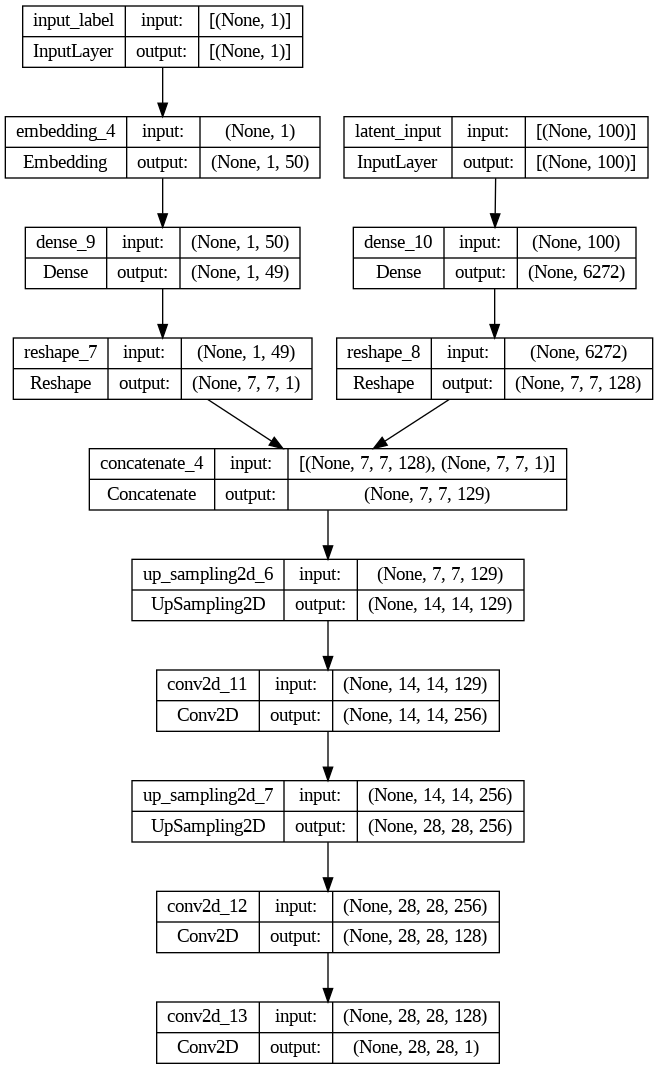

In [ ]:
plot_model(G_model,show_shapes=True,show_layer_names=True,expand_nested=True)

In [178]:
xtrain=np.expand_dims(xtrain,axis=-1)
xtrain=xtrain/255.

In [179]:
dataset = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
dataset = dataset.shuffle(60000).batch(B_size)

ValueError: Dimensions 60000 and 1 are not compatible

In [177]:
x,y=dataset.as_numpy_iterator().next()
print(x.shape)

(512, 28, 28, 1)


In [124]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

# 4.Custom Trainning Loop:
-----------------

In [161]:
def model(input_shape,n_classes=10):
  inp_img=Input(shape=input_shape ,name="image")

  x=Conv2D(64, 3, activation = 'relu')(inp_img)
  x=MaxPooling2D((2,2))(x)
  x=Conv2D(64, 3, activation= 'relu')(x)
  x=MaxPooling2D((2,2))(x)

  x=Flatten()(x)
  x=Dense(32,activation='relu')(x)
  output=Dense(1,activation="softmax")(x)
  model = Model(inputs=inp_img ,outputs=output,name="model")
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
  return model

In [162]:
model=model((28,28,1),n_classes=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0     

In [171]:
## custom Trainning loop:
class Custom_Loop(Model):
          

  @staticmethod
  def formating(x,label,batch_size):
    label=tf.expand_dims(label,axis=-1)
    y=tf.ones((batch_size,1))
    return([x,label],y)


  @staticmethod
  def generate_latent(n_batches,latent_dim=100,n_classes=10):
        x = tf.random.normal(shape=[n_batches * latent_dim])
        x = tf.reshape(x, [n_batches, latent_dim])
        label = tf.random.uniform(shape=[n_batches], minval=0, maxval=n_classes, dtype=tf.int32)   
        label = tf.expand_dims(label, axis=-1)
        return ([x,label]) 


  @staticmethod
  def Generate_fakes(Generator,batch_size,latent_dim=100):
        x,label=Custom_Loop.generate_latent(batch_size,latent_dim)
        fake_img=Generator([x,label],training=False)
        y=tf.zeros((batch_size,1))
        return [fake_img,label],y
    
        
  @staticmethod
  def conc(x,y,batch_size,Generator):
        [xreal,label_real],yreal=Custom_Loop.formating(x,y,batch_size)
        [xfake,label_fake],yfake=Custom_Loop.Generate_fakes(Generator,batch_size)
        xreal = tf.cast(xreal, tf.float32)  
        x = tf.concat([xreal, xfake], axis=0)
        label = tf.concat([label_real, label_fake], axis=0)
        y = tf.concat([yreal, yfake], axis=0)
        return ([x,label],y)
    
    

  def __init__(self,D_model,G_model,batch_size,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.Discrimnator=D_model
    self.Generator=G_model
    self.batch_size=batch_size
    self.callbacks = [] 


  def compile(self,D_loss,D_optimizer,*args,**kwargs):
    super().compile(*args,**kwargs)
    self.D_loss=D_loss
    self.D_opt=D_optimizer
    #self.G_loss=G_loss
    #self.G_opt=G_opt


  def train_step(self,data):
    x,y=data 
    with tf.GradientTape() as D_tape:
        yhat=self.Discrimnator(x,training=True)
        loss=self.D_loss(y,yhat)
    d_grad=D_tape.gradient(loss, self.Discrimnator.trainable_weights)
    self.D_opt.apply_gradients(zip(d_grad,self.Discrimnator.trainable_weights))
    return f"dloss{loss}"



In [172]:
Train=Custom_Loop(model,G_model,B_size)

In [173]:
#compile Models:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
Train.compile(D_loss=SparseCategoricalCrossentropy(),D_optimizer=Adam(learning_rate=1e-3))

In [181]:
step=len(dataset)
#print(step)
Train.fit(xtrain,ytrain,epochs=1000,batch_size=B_size)

Epoch 1/1000


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\ahmed\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ahmed\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ahmed\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ahmed\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ahmed\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ahmed\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ahmed\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\ahmed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ahmed\AppData\Local\Temp\ipykernel_17468\1790901015.py", line 3, in <module>
      Train.fit(xtrain,ytrain,epochs=1000,batch_size=B_size)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ahmed\AppData\Local\Temp\ipykernel_17468\284170718.py", line 61, in train_step
      loss=self.D_loss(y,yhat)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\ahmed\anaconda3\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [1,512] and labels shape [512]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_20876]

In [145]:
from tqdm import tqdm

class KerasProgessCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.pbar = tqdm(total=self.params['epochs'])

    def on_epoch_end(self, batch, logs={}):
        self.pbar.update(1)

    def on_train_end(self, logs={}):
        self.pbar.close()


In [ ]:
def train(Discrimnator,Generator,Gan,latent_dim,dataset,n_batches=128,n_epoches=100):
  batch_per_epoch=int(dataset[0].shape[0]/n_batches)
  half_batch=int(n_batches/2)
  for epoch in range(n_epoches):
    print(f"Epoch {epoch}/{n_epoches}: ")
    for n_batch in range(batch_per_epoch):
      zreal,yreal=generate_real(dataset,half_batch)
      d1loss,_=Discrimnator.train_on_batch(zreal,yreal)
      zfake,yfake=gen_from_gen(Generator,latent_dim,half_batch)
      d2loss,_=Discrimnator.train_on_batch(zfake,yfake)
      gan_inp=generate_latent(latent_dim,n_batches)
      y_gan=np.ones(shape=(n_batches,1))
      gloss=Gan(gan_inp,y_gan)
      print(f"Epoch {epoch}/{n_epoches}: D1_loss:{d1loss} , D2_loss: {d2loss} , G_loss: {gloss[0][0]} ")
    Generator.save("Generator.hdf5")
    Discrimnator.save("Discrimnator.hdf5")

In [116]:
x,y=dataset.as_numpy_iterator().next()
x=np.expand_dims(x[0],axis=0)
y=np.expand_dims(y[0],axis=0)

In [118]:
result=D_model.predict([x,y])

1/1 [==============================] - 3s 3s/step


In [119]:
result

array([[0.76978344]], dtype=float32)

In [122]:
loss = tf.keras.losses.binary_crossentropy(1.0,result).numpy()
print(loss)

[0.2616459]
